<a href="https://colab.research.google.com/github/baochi0212/ML_project_midterm-/blob/master/ML__midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SET UP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/data_ml_midterm /content

In [3]:
!cp "/content/drive/MyDrive/ml_midterm_last (4).zip" data.zip

In [4]:
!unzip data.zip

Archive:  data.zip
  inflating: ml_midterm_last/test.ftr  
  inflating: ml_midterm_last/train.ftr  
  inflating: ml_midterm_last/train_augment_all.ftr  
  inflating: ml_midterm_last/train_augment1.ftr  
  inflating: ml_midterm_last/val.ftr  
  inflating: ml_midterm_last/val_augment_all.ftr  
  inflating: ml_midterm_last/val_augment1.ftr  


In [5]:
!pip install -q catboost xgboost

     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [6]:
!git clone https://github.com/davisking/dlib-models #pretrained 
!bunzip2 /content/dlib-models/shape_predictor_68_face_landmarks.dat.bz2
#landmarks 
import cv2
import dlib
#face detector and facial landmarks
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/dlib-models/shape_predictor_68_face_landmarks.dat") #pretrained path here

Cloning into 'dlib-models'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 186 (delta 17), reused 11 (delta 1), pack-reused 154
Receiving objects: 100% (186/186), 408.51 MiB | 24.04 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Checking out files: 100% (16/16), done.


In [7]:
from skimage.feature import hog
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import joblib
from sklearn.preprocessing import MinMaxScaler
import cv2
import dlib
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb 
import xgboost as xgb
import catboost as cat 
#scale
sc = MinMaxScaler()


#START HERE

## EDA

In [8]:
#start the pipeline here 
train_df = pd.read_feather("/content/ml_midterm_last/train.ftr")
train_df1 = pd.read_feather("/content/ml_midterm_last/train_augment1.ftr")
train_df2 = pd.read_feather("/content/ml_midterm_last/train_augment_all.ftr")
val_df = pd.read_feather("/content/ml_midterm_last/val.ftr")
test_df = pd.read_feather("/content/ml_midterm_last/test.ftr")

In [9]:
def get_class_plot(df, name=None):
    label = np.arange(len(df['label'].value_counts().index))
    value = df['label'].value_counts().values
    fig, ax = plt.subplots()
    #val
    ax.bar(label, value)
    #title
    if name:
        ax.set_title(name)
    plt.show()

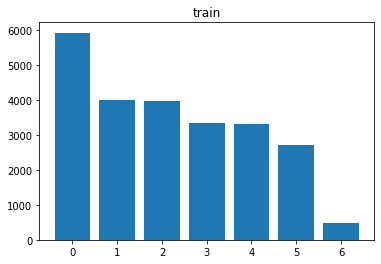

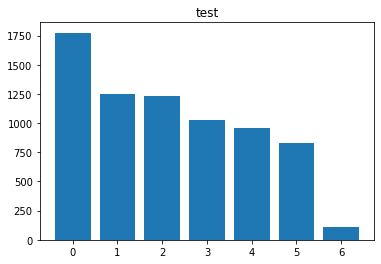

In [10]:
get_class_plot(train_df, "train"), get_class_plot(test_df, "test")
plt.show()

In [11]:
len(test_df)

7178

## feature engineer 

In [ ]:
#can activate the plot option for trial image showcase
def get_hog_features(df, plot=True):
    features = np.array([])
    #get the features
    for i in range(len(df)):
        image = Image.fromarray(np.array(df['pixel'][i].tolist()).reshape(48, 48).astype(np.uint8))
        fd = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=False)
        if plot:
            _, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)
            fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))
            ax1.imshow(hog_image)
            ax2.imshow(image)
            plt.show()
            break
        features = np.concatenate([features, fd], axis=0)
    return features.reshape(len(df), -1)

#landmarks
def get_landmarks_features(df):
    landmark_fd = []
    for i in range(len(df)):
        image = np.array(df['pixel'][i].tolist()).reshape(48, 48)
        #landmarks object
        res = predictor(image.astype(np.uint8), dlib.rectangle(0, 0, 48, 48))
        landmarks = []
        #68 landmarks
        for i in range(68):
          landmarks.append(res.part(i).x)
          landmarks.append(res.part(i).y)
        landmark_fd.append(landmarks)
    return sc.fit_transform(np.array(landmark_fd).reshape(len(df), -1))        

In [ ]:
#can choose the feature to use
def feature_and_label(df, mode='landmark'):
    
    landmark_feature = get_landmarks_features(df)
    label = df['label']
    if mode == 'landmark':
      return landmark_feature, label
    else:
      hog_feature = get_hog_features(df, plot=False)
      feature = np.concatenate([hog_feature, landmark_feature], axis=1)
      return feature, label

# X_train, y_train = feature_and_label(train_df)
# X_train1, y_train1 = feature_and_label(train_df1)
# X_train2, y_train2 = feature_and_label(train_df2)
# X_test, y_test = feature_and_label(test_df)


## tuning model with landmarks

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print("naive Bayes", acc)

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train1, y_train1).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print("naive Bayes", acc)

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train2, y_train2).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print("naive Bayes", acc)

### Neareast Neighbors 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighbor_cls = KNeighborsClassifier(n_neighbors=1)
# grid_search = GridSearchCV(estimator=neighbor_cls, param_grid={'n_neighbors': [1, 20]})

y_pred = neighbor_cls.fit(X_train, y_train).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"KNN ", acc) #1 NN g  et 37 ... 37,129


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighbor_cls = KNeighborsClassifier(n_neighbors=1)
# grid_search = GridSearchCV(estimator=neighbor_cls, param_grid={'n_neighbors': [1, 20]})

y_pred = neighbor_cls.fit(X_train1, y_train1).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"KNN ", acc) #1 NN g  et 37 ... 37,129


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighbor_cls = KNeighborsClassifier(n_neighbors=1)
# grid_search = GridSearchCV(estimator=neighbor_cls, param_grid={'n_neighbors': [1, 20]})

y_pred = neighbor_cls.fit(X_train2, y_train2).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"KNN ", acc) #1 NN g  et 37 ... 37,129


### Light GBM

In [ ]:
#light gbm
model = lgb.LGBMClassifier(max_depth=6, random_state=314, silent=True, metric='None', n_estimators=300)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"lgbm", acc) #1 NN g  et 37 ... 37,129

In [ ]:
model = lgb.LGBMClassifier(max_depth=6, random_state=314, silent=True, metric='None', n_estimators=300)
model.fit(X_train1, y_train1)
y_pred = model.predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"lgbm", acc) #1 NN g  et 37 ... 37,129

In [ ]:
model = lgb.LGBMClassifier(max_depth=9, random_state=314, silent=True, metric='None', n_estimators=3000)
model.fit(X_train2, y_train2)
y_pred = model.predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"lgbm", acc) #1 NN g  et 37 ... 37,129

### XG Boost

In [ ]:
#xgboost
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"xgb", acc) #1 NN g  et 37 ... 37,129

In [ ]:
#xgboost
model = xgb.XGBClassifier()
model.fit(X_train1, y_train1)
y_pred = model.predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"xgb", acc) #1 NN g  et 37 ... 37,129

In [ ]:
#xgboost
model = xgb.XGBClassifier()
model.fit(X_train2, y_train2)
y_pred = model.predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"xgb", acc) #1 NN g  et 37 ... 37,129

In [ ]:
X_train1.shape, X_train.shape

### CatBoost

In [ ]:
#xgboost
model = cat.CatBoostClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = (y_pred.reshape(-1) == y_test).sum()/y_test.shape[0]
print(f"catboost", acc) #1 NN g  et 37 ... 37,129

In [ ]:
#xgboost
model = cat.CatBoostClassifier()
model.fit(X_train1, y_train1)
y_pred = model.predict(X_test)
acc = (y_pred.reshape(-1) == y_test).sum()/y_test.shape[0]
print(f"catboost", acc) #1 NN g  et 37 ... 37,129

In [ ]:
#xgboost
model = cat.CatBoostClassifier()
model.fit(X_train2, y_train2)
y_pred = model.predict(X_test)
acc = (y_pred.reshape(-1) == y_test).sum()/y_test.shape[0]
print(f"catboost", acc) #1 NN g  et 37 ... 37,129

### SVM


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
grid_search = GridSearchCV(estimator=SVC(), param_grid={'C': [1, 2, 4, 5, 9, 15, 20]})
y_pred = grid_search.fit(X_train, y_train).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"{grid_searh.best_estimator_}", acc) #1 NN get 37 ... 37,129

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
y_pred = SVC(C=9, kernel='rbf').fit(X_train1, y_train1).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print("SVM", acc) #1 NN get 37 ... 37,129

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
y_pred = SVC(C=9, kernel='rbf').fit(X_train2, y_train2).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print("SVM", acc) #1 NN get 37 ... 37,129

# Visualize the landmarks result

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Landmark features ')

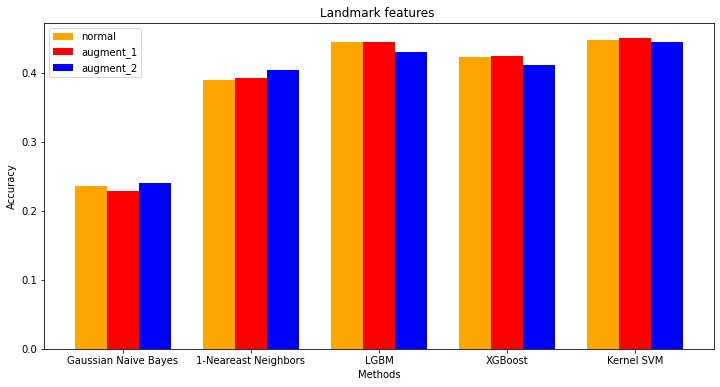

In [ ]:
label = ['Gaussian Naive Bayes', '1-Neareast Neighbors', 'LGBM', 'XGBoost', 'Kernel SVM']
label_array = np.array([2,4,6,8,10])
dict_result = {
    'normal': [0.236, 0.389, 0.445,  0.422, 0.447],
    'augment1': [0.229, 0.393, 0.445, 0.4236,  0.450], 
    'augment2': [0.240, 0.404, 0.430, 0.411,  0.444]
}
#label, value,  width, color
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(label_array - 0.5, dict_result['normal'], color='orange', width=0.5, label='normal')
ax.bar(label_array, dict_result['augment1'], color='red', width=0.5, label='augment_1')
ax.bar(label_array + 0.5, dict_result['augment2'], color='blue', width=0.5, label='augment_2')
ax.set_xticklabels(np.concatenate([np.array([0]), label]))
ax.set_xlabel("Methods")
ax.set_ylabel("Accuracy")
ax.legend()
ax.set_title("Landmark features ")

#Apply to full features

##full feature data

In [15]:
from sklearn.metrics import classification_report

In [16]:
X_train = pd.read_feather("/content/data_ml_midterm/data.ftr").iloc[:, 0].values
X_train = np.array(X_train.tolist()).reshape(len(X_train), -1)
y_train = pd.read_feather("/content/data_ml_midterm/data.ftr").iloc[:, 1].values 

In [17]:
X_train1 = pd.read_feather("/content/data_ml_midterm/data1.ftr").iloc[:, 0].values
X_train1 = np.array(X_train1.tolist()).reshape(len(X_train1), -1)
y_train1 = pd.read_feather("/content/data_ml_midterm/data1.ftr").iloc[:, 1].values 

In [18]:
X_test = pd.read_feather("/content/data_ml_midterm/data_test.ftr").iloc[:, 0].values
X_test = np.array(X_test.tolist()).reshape(len(X_test), -1)
y_test = pd.read_feather("/content/data_ml_midterm/data_test.ftr").iloc[:, 1].values 

In [19]:
X_train2 = pd.read_feather("/content/data_ml_midterm/data2.ftr").iloc[:, 0].values
X_train2 = np.array(X_train2.tolist()).reshape(len(X_train2), -1)
y_train2 = pd.read_feather("/content/data_ml_midterm/data2.ftr").iloc[:, 1].values 

In [20]:
#validation
X_val = pd.read_feather("/content/data_ml_midterm/val.ftr").iloc[:, 0].values
X_val = np.array(X_val.tolist()).reshape(len(X_val), -1)
y_val = pd.read_feather("/content/data_ml_midterm/val.ftr").iloc[:, 1].values 

In [21]:
result_dict = {'1-KNN': 0, 'LGBM': 0, 'XGB': 0, 'Kernel SVM': 0}

## Naive Bayes

In [22]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print("naive Bayes", acc)

naive Bayes 0.33365840066870994


In [23]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train1, y_train1).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print("naive Bayes", acc)

naive Bayes 0.3265533574811925


In [24]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train2, y_train2).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print("naive Bayes", acc)

naive Bayes 0.33059348007801614


## Neareast Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighbor_cls = KNeighborsClassifier(n_neighbors=1)
# grid_search = GridSearchCV(estimator=neighbor_cls, param_grid={'n_neighbors': [1, 20]})

y_pred = neighbor_cls.fit(X_train, y_train).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"KNN ", acc) #1 NN g  et 37 ... 37,129


KNN  0.4927556422401783


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighbor_cls = KNeighborsClassifier(n_neighbors=1)
# grid_search = GridSearchCV(estimator=neighbor_cls, param_grid={'n_neighbors': [1, 20]})

y_pred = neighbor_cls.fit(X_train1, y_train1).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"KNN ", acc) #1 NN g  et 37 ... 37,129


KNN  0.49150181108943997


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neighbor_cls = KNeighborsClassifier(n_neighbors=1)
# grid_search = GridSearchCV(estimator=neighbor_cls, param_grid={'n_neighbors': [1, 20]})

y_pred = neighbor_cls.fit(X_train2, y_train2).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"KNN ", acc) #1 NN g  et 37 ... 37,129


KNN  0.5069657286152132


In [ ]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.38      0.44      0.41       837
           1       0.61      0.49      0.54       139
           2       0.42      0.47      0.44       912
           3       0.69      0.58      0.63      2107
           4       0.46      0.41      0.43      1371
           5       0.34      0.44      0.38       974
           6       0.67      0.67      0.67       838

    accuracy                           0.51      7178
   macro avg       0.51      0.50      0.50      7178
weighted avg       0.53      0.51      0.51      7178



In [ ]:
type(classification_report(y_pred, y_test))

str

## Light GBM

In [ ]:
#light gbm
model = lgb.LGBMClassifier(max_depth=6, random_state=314, silent=True, metric='None', n_estimators=3000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"lgbm", acc) #1 NN g  et 37 ... 37,129

In [ ]:
model = lgb.LGBMClassifier(max_depth=6, random_state=314, silent=True, metric='None', n_estimators=1500)
model.fit(X_train1, y_train1)
y_pred = model.predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"lgbm", acc) #1 NN g  et 37 ... 37,129

lgbm 0.5463917525773195


In [ ]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.30      0.56      0.39       507
           1       0.39      0.86      0.53        50
           2       0.32      0.46      0.37       707
           3       0.86      0.62      0.72      2481
           4       0.53      0.49      0.51      1340
           5       0.43      0.40      0.41      1359
           6       0.66      0.75      0.70       734

    accuracy                           0.55      7178
   macro avg       0.50      0.59      0.52      7178
weighted avg       0.60      0.55      0.56      7178



##SVM

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
grid_search = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid={'C': [6, 9]})
y_pred = SVC(kernel='rbf', C=15).fit(X_train, y_train).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"SVM", acc) #1 NN get 37 ... 37,129

SVM 0.5558651434940095


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
grid_search = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid={'C': [9, 12, 15]})
y_pred = SVC(kernel='rbf', C=15).fit(X_train1, y_train1).predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"SVM", acc) #56.2

SVM 0.5633881303984397


In [ ]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.31      0.59      0.41       509
           1       0.57      0.67      0.61        94
           2       0.34      0.48      0.40       730
           3       0.83      0.65      0.73      2270
           4       0.58      0.48      0.52      1492
           5       0.42      0.46      0.44      1132
           6       0.76      0.66      0.71       951

    accuracy                           0.56      7178
   macro avg       0.54      0.57      0.54      7178
weighted avg       0.61      0.56      0.58      7178



##XG BOOST

In [ ]:
#xgboost
model = xgb.XGBClassifier(max_depth=6, random_state=314, silent=True, metric='None', n_estimators=2000)
model.fit(X_train1, y_train1)
y_pred = model.predict(X_test)
acc = (y_pred == y_test).sum()/y_test.shape[0]
print(f"xgb", acc) #1 NN g  et 37 ... 37,129

##NEURAL NET


In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
class SimpleModel(nn.Module):
  def __init__(self, dim_in, num_classes, dim_hidden):
    super().__init__()
    self.linear1 = nn.Linear(dim_in, dim_hidden)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(dim_hidden, 256)
    self.relu2 = nn.ReLU()
    self.linear3 = nn.Linear(256, 128)
    self.relu3 = nn.ReLU()
    self.linear4 = nn.Linear(128, num_classes)
    self.relu4 = nn.ReLU()
    self.dropout = nn.Dropout(0.1)


  def forward(self, x):
    x = self.relu1(self.linear1(x))
    x = self.dropout(x)
    x = self.relu2(self.linear2(x))
    x = self.relu3(self.linear3(x))
    x = self.relu4(self.linear4(x))
    return x
  




In [14]:
class SimpleDataset(Dataset):
  def __init__(self, data, label):
    super().__init__()
    self.data = data
    self.label = label

  def __getitem__(self, idx):
    return torch.tensor(self.data[idx]), torch.tensor(self.label[idx], dtype=torch.long)

  def __len__(self):
    return len(self.data)

In [ ]:
dataset = SimpleDataset(X_train1, y_train1)
dataloader = DataLoader(dataset, batch_size=32, drop_last=True, shuffle=True)

In [ ]:
val_dataset = SimpleDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleModel(dim_in=1036, dim_hidden=512, num_classes=7).to(device)
optim = torch.optim.S(lr=0.0001, params=model.parameters())
val_loss = []
val_acc = []

In [ ]:
def train(loader, model, optim, num_epochs=9):
  count = 0
  
  model.train()
  for i in range(num_epochs):
    val_total = 0
    true = 0
    for data, label in tqdm(loader):
      count += 1
      optim.zero_grad()
      data, label = data.to(device), label.to(device)
      loss = nn.CrossEntropyLoss()(model(data.float()), label)
      loss.backward()
      optim.step()
    model.eval()
    for data, label in tqdm(val_dataloader):

      data, label = data.to(device), label.to(device)
      loss = nn.CrossEntropyLoss()(model(data.float()), label)
      val_total += loss.item()
      if torch.argmax(model(data.float().cuda()), dim=-1).reshape(-1).item() == label.item():
        true += 1
    val_loss.append(val_total)
    val_acc.append(true/len(val_dataloader))
               


      


In [ ]:
train(dataloader, model, optim, num_epochs=30)

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/5938 [00:00<?, ?it/s]

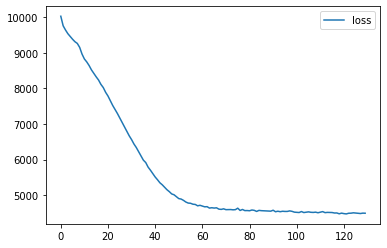

In [ ]:
plt.plot(val_loss, label="loss")
plt.legend()

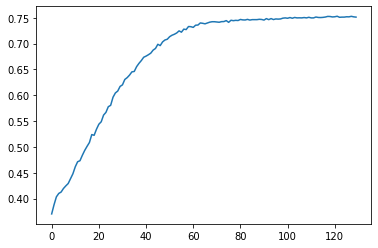

In [ ]:
plt.plot(val_acc, label="acc")

In [ ]:
test_dataset = SimpleDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=1, drop_last=True, shuffle=True)

#testing
true = 0
model.eval()
for data, label in test_dataloader:
  if torch.argmax(model(data.float().cuda()), dim=-1).reshape(-1).item() == label:
    true += 1

true/len(test_dataset)

0.43243243243243246

##COMPARE

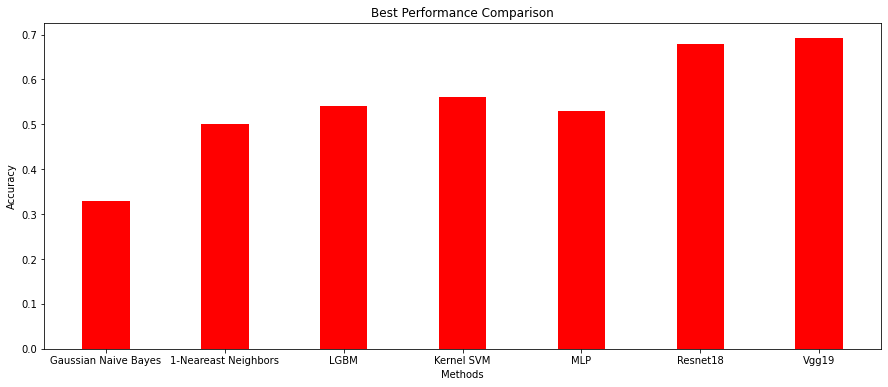

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
label = ['Gaussian Naive Bayes', '1-Neareast Neighbors', 'LGBM', 'Kernel SVM', 'MLP', 'Resnet18', 'Vgg19']
label_array = np.array([2,4,6,8,10,12,14])
dict_result = {
    'result': [0.33, 0.50, 0.54,  0.56, 0.53, 0.68, 0.692],
}
#label, value,  width, color
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(label_array, dict_result['result'], color='red', width=0.8, label='augment_1')
ax.set_xticklabels(np.concatenate([np.array([0]), label]))
ax.set_xlabel("Methods")
ax.set_ylabel("Accuracy")
ax.set_title("Best Performance Comparison")
plt.show()

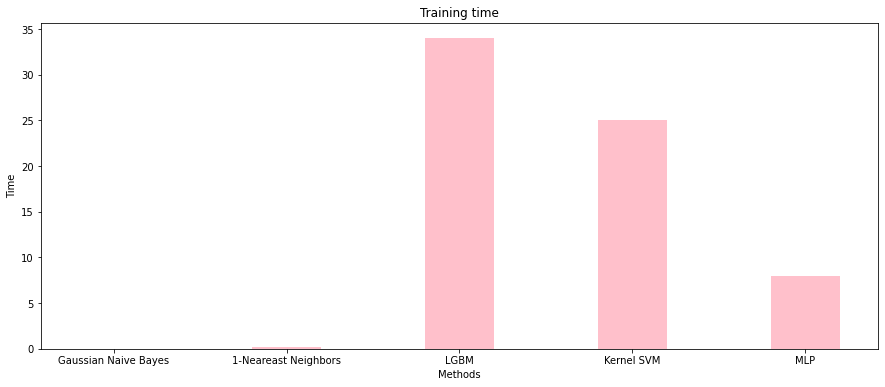

In [ ]:
label = ['Gaussian Naive Bayes', '1-Neareast Neighbors', 'LGBM', 'Kernel SVM', 'MLP']
label_array = np.array([2,4,6,8,10])
dict_result = {
    'Training time': [1/60, 1/6, 34,  25, 8],
}
#label, value,  width, color
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(label_array, dict_result['Training time'], color='pink', width=0.8, label='augment_1')
ax.set_xticklabels(np.concatenate([np.array([0]), label]))
ax.set_xlabel("Methods")
ax.set_ylabel("Time")
ax.set_title("Training time")
plt.show()

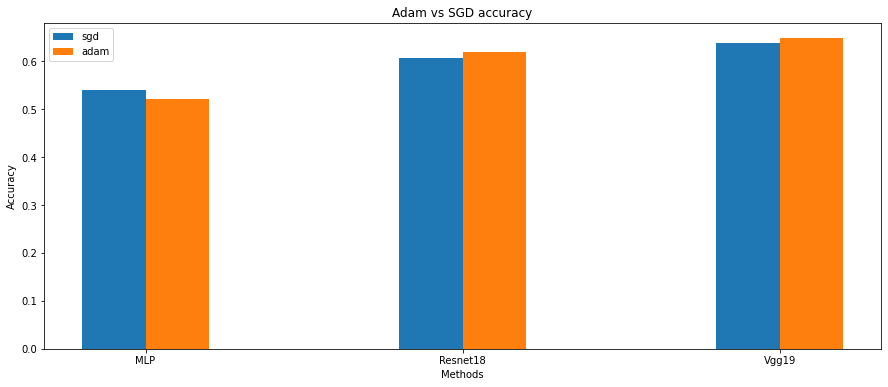

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
label = ['MLP', 'Resnet18', 'Vgg19']
label_array = np.arange(len(label))
sgd = [0.54, 0.6066, 0.6379]
adam = [0.52, 0.62, 0.6479]
#label, value,  width, color
ax.bar(label_array - 0.1, sgd, width=0.2, label='sgd')
ax.bar(label_array + 0.1, adam, width=0.2, label='adam')
# ax.set_xticklabels(np.concatenate([np.array([0]), label]))
ax.set_xlabel("Methods")
ax.xaxis.set_ticks(np.arange(3)) #divide the range
ax.set_xticklabels(label)
ax.set_ylabel("Accuracy")
ax.legend()
ax.set_title("Adam vs SGD accuracy")
plt.show()

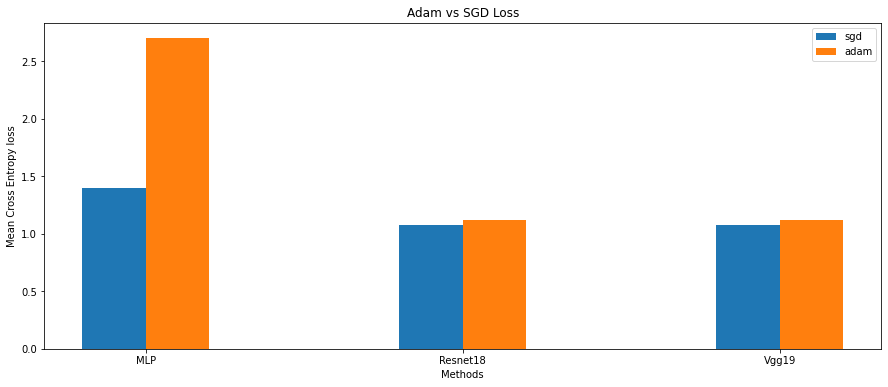

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
label = ['MLP', 'Resnet18', 'Vgg19']
label_array = np.arange(len(label))
sgd = [1.4, 1.08, 1.08]
adam = [2.7, 1.119, 1.12]
#label, value,  width, color
ax.bar(label_array - 0.1, sgd, width=0.2, label='sgd')
ax.bar(label_array + 0.1, adam, width=0.2, label='adam')
# ax.set_xticklabels(np.concatenate([np.array([0]), label]))
ax.set_xlabel("Methods")
ax.xaxis.set_ticks(np.arange(3)) #divide the range
ax.set_xticklabels(label)
ax.set_ylabel("Mean Cross Entropy loss")
ax.set_title("Adam vs SGD Loss")
ax.legend()
plt.show()

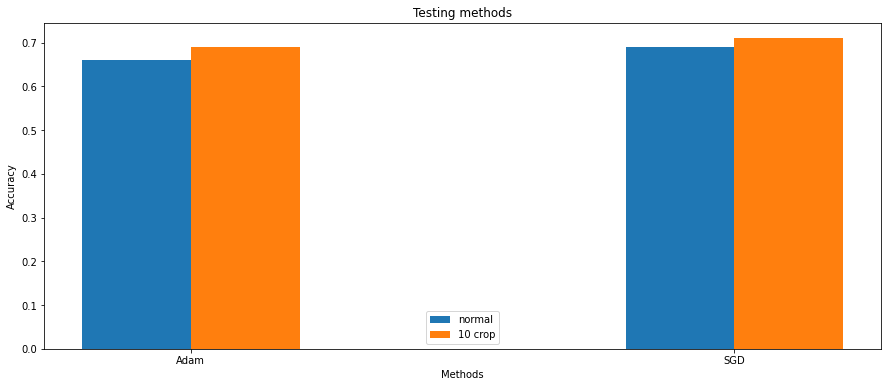

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
label = ['Adam', 'SGD']
label_array = np.arange(len(label))
sgd = [0.66, 0.69]
adam = [0.69, 0.71]
#label, value,  width, color
ax.bar(label_array - 0.1, sgd, width=0.2, label='normal')
ax.bar(label_array + 0.1, adam, width=0.2, label='10 crop')
# ax.set_xticklabels(np.concatenate([np.array([0]), label]))
ax.set_xlabel("Methods")
ax.xaxis.set_ticks(np.arange(2)) #divide the range
ax.set_xticklabels(label)
ax.set_ylabel("Accuracy")
ax.set_title("Testing methods")
ax.legend()
plt.show()

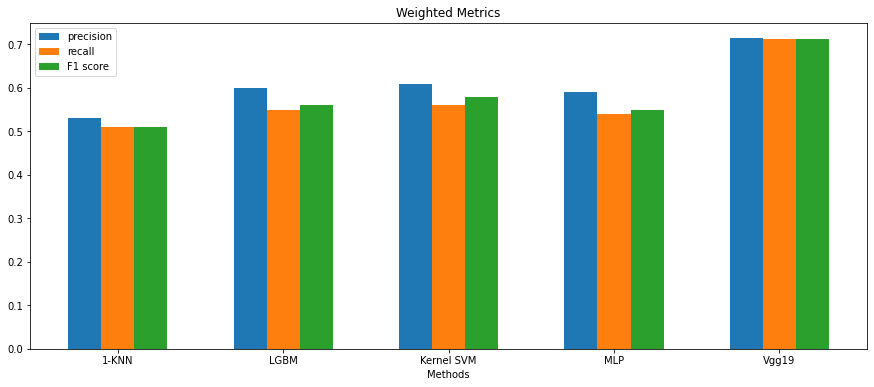

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
label = ['1-KNN', 'LGBM', 'Kernel SVM', 'MLP', 'Vgg19']
label_array = np.arange(len(label))
precision = [0.53, 0.6, 0.61, 0.59, 0.7144]
recall = [0.51, 0.55, 0.56, 0.54, 0.7129] 
F1 = [0.51, 0.56, 0.58, 0.55, 0.7125]
#label, value,  width, color
ax.bar(label_array - 0.2, precision, width=0.2, label='precision')
ax.bar(label_array, recall, width=0.2, label='recall')
ax.bar(label_array + 0.2, F1, width=0.2, label='F1 score')
# ax.set_xticklabels(np.concatenate([np.array([0]), label]))
ax.set_xlabel("Methods")
ax.xaxis.set_ticks(np.arange(5)) #divide the range
ax.set_xticklabels(label)
ax.set_ylabel("")
ax.set_title("Weighted Metrics")
ax.legend()
plt.show()

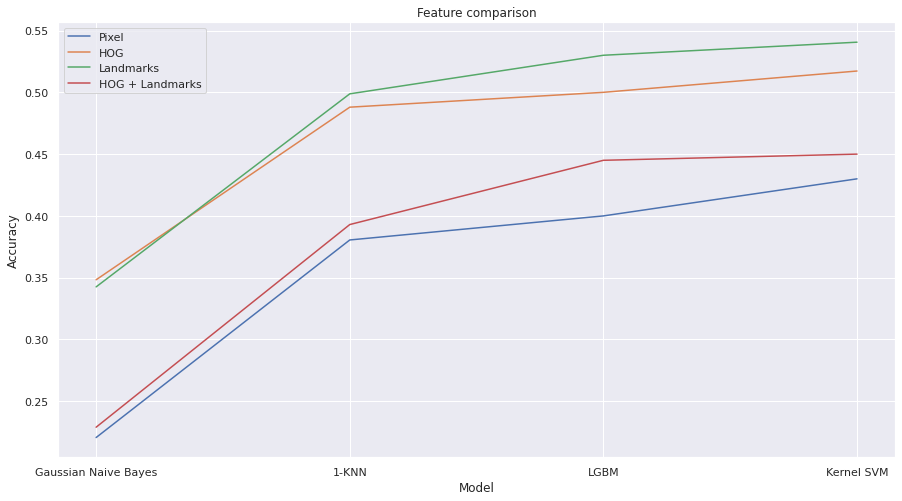

In [ ]:
import seaborn as sns 

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot([0.22065482410309997, 0.38052943225357017, 0.4, 0.43])
ax.plot([0.34831069313827934, 0.48798328108672934, 0.5, 0.5172413793103449])
ax.plot([0.34256356670149773, 0.498780912574016,  0.53, 0.5405781957506095])
ax.plot([0.229, 0.393, 0.445, 0.450])
x_ticks = ["Gaussian Naive Bayes", "1-KNN", "LGBM", "Kernel SVM"]
ax.set_xticks(np.arange(len(x_ticks)))
ax.set_xticklabels(x_ticks)
ax.set(xlabel ='Model', ylabel ='Accuracy',
       title = "Accuracy for 4 models")
ax.legend(["Pixel", "HOG", "Landmarks", "HOG + Landmarks"])
ax.set_title("Feature comparison")
sns.set_theme()
plt.show()